In [1]:
import time
import matplotlib.pyplot as plt

from sast.utils import *
from sast.sast import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV


In [2]:
lab = False # True if I am on my lab computer
#ds_folder = '/home/mimbouop/ucr_dataset' if lab else '/home/michael/Projects/USTC/dataset/Shapelet_ucr'
ds_folder = r'C:\Users\Nicolas R\Documents\sast-nrv'
ds_name = 'Chinatown'
random_state = None

# Loading the dataset

In [3]:
train_ds, test_ds = load_dataset(ds_folder, ds_name)

X_train, y_train = format_dataset(train_ds, shuffle=True)
X_test, y_test = format_dataset(test_ds)

print(train_ds, y_train, end='\n\n')


     att1   att2   att3   att4   att5  att6  att7   att8   att9  att10  ...  \
0   573.0  375.0  301.0  212.0   55.0  34.0  25.0   33.0  113.0  143.0  ...   
1   394.0  264.0  140.0  144.0  104.0  28.0  28.0   25.0   70.0  153.0  ...   
2   603.0  348.0  176.0  177.0   47.0  30.0  40.0   42.0  101.0  180.0  ...   
3   428.0  309.0  199.0  117.0   82.0  43.0  24.0   64.0  152.0  183.0  ...   
4   372.0  310.0  203.0  133.0   65.0  39.0  27.0   36.0  107.0  139.0  ...   
5   448.0  344.0  183.0  146.0   71.0  14.0  30.0   41.0  108.0  137.0  ...   
6   621.0  322.0  221.0  150.0   65.0  40.0  42.0   84.0  148.0  190.0  ...   
7   597.0  409.0  142.0   93.0   48.0  30.0  34.0   87.0  132.0  157.0  ...   
8   525.0  431.0  248.0  240.0   91.0  64.0  29.0  117.0  200.0  236.0  ...   
9   587.0  382.0  165.0  192.0  130.0  44.0  21.0   35.0   73.0  132.0  ...   
10  144.0   73.0   21.0   16.0   10.0  12.0  26.0  100.0  177.0  220.0  ...   
11  141.0   63.0   51.0   14.0   16.0  14.0  28.0  1

In [4]:
print(test_ds, y_test)

      att1   att2   att3   att4   att5   att6  att7   att8   att9  att10  ...  \
0    501.0  328.0  195.0  218.0   67.0   17.0  28.0   72.0  132.0  215.0  ...   
1    880.0  752.0  913.0  863.0  402.0  112.0  60.0  112.0  119.0  186.0  ...   
2    493.0  389.0  174.0  121.0   82.0   36.0  27.0   64.0  127.0  203.0  ...   
3    616.0  323.0  162.0  166.0   68.0   26.0  34.0   68.0  123.0  263.0  ...   
4    389.0  276.0  161.0  124.0   35.0   26.0  51.0   75.0   71.0  126.0  ...   
..     ...    ...    ...    ...    ...    ...   ...    ...    ...    ...  ...   
338  140.0   57.0   45.0   32.0   19.0   23.0  32.0   89.0  159.0  207.0  ...   
339  120.0   57.0   37.0   28.0   13.0   14.0  18.0   80.0  187.0  174.0  ...   
340  207.0  147.0   71.0   57.0   39.0   29.0  36.0   85.0  240.0  210.0  ...   
341  293.0  180.0   73.0   96.0   85.0   44.0  86.0  159.0  218.0  414.0  ...   
342  149.0   88.0   39.0   30.0   22.0    9.0  30.0   64.0  215.0  267.0  ...   

      att16   att17   att18

## Plot some train instances

In [5]:
classes = np.unique(y_train)
count_per_classes = 1 # Number of instances to plot per each class
max_class_to_plot = min(3, len(classes)) # Number of classes to consider

shape train DS: (20, 25)
classes: [1 2] count_per_classes= 1 max_class_to_plot= 2
i= 0 c= 1
y_train==c: [ 0  3  4  6  9 11 12 13 14 17]
ts_indices: [ 6 14]
idx= 6
i= 1 c= 2
y_train==c: [ 1  2  5  7  8 10 15 16 18 19]
ts_indices: [8 1]
idx= 8
1


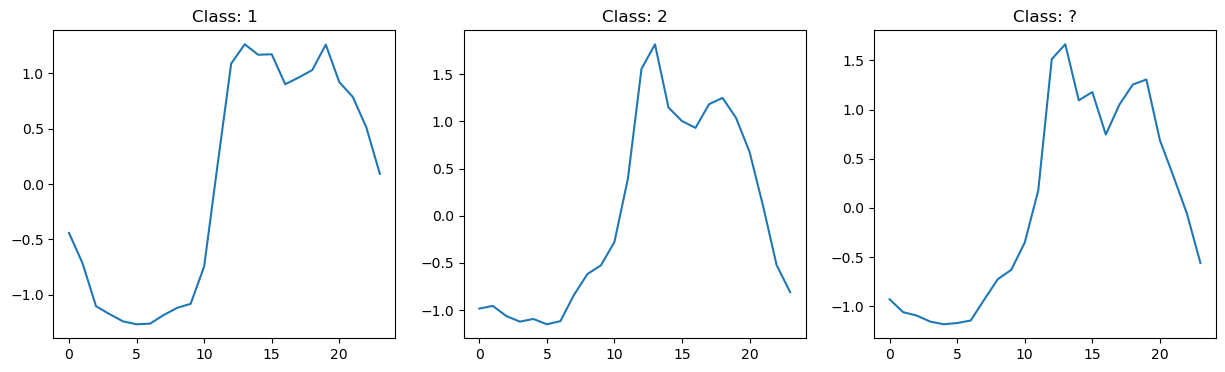

In [6]:
print("shape train DS:", train_ds.shape)
print("classes:",classes,"count_per_classes=", count_per_classes,"max_class_to_plot=", max_class_to_plot)
plt.figure(figsize=(15, 4))

for i, c in enumerate(classes[:max_class_to_plot]):
    print ("i=",i,"c=",c)
    print ("y_train==c:",np.where(y_train==c)[0])
    ts_indices = np.random.choice(np.where(y_train==c)[0], size=count_per_classes+1, replace=False)
    print ("ts_indices:",ts_indices)
    plt.subplot(1, max_class_to_plot+1, i+1)
    for idx in ts_indices[:-1]:
        print("idx=",idx)
        plt.plot(znormalize_array(X_train[idx])) # z-normalize the times series to make sure they are on the same scale
    plt.title(f'Class: {c}')
    
plt.subplot(1, max_class_to_plot+1, i+2)
plt.plot(znormalize_array(X_train[ts_indices[-1]]))
print(ts_indices[-1])
plt.title(f'Class: ?')
plt.savefig(fname='images/chinatown-one-instance-classification.jpg')



shape train DS: (20, 25)
classes: [1 2] count_per_classes= 4 max_class_to_plot= 2
i= 0 c= 1
y_train==c: [ 0  3  4  6  9 11 12 13 14 17]
ts_indices: [ 9  0 11  6 12]
idx= 9
idx= 0
idx= 11
idx= 6
i= 1 c= 2
y_train==c: [ 1  2  5  7  8 10 15 16 18 19]
ts_indices: [16  8  2 10  1]
idx= 16
idx= 8
idx= 2
idx= 10
1


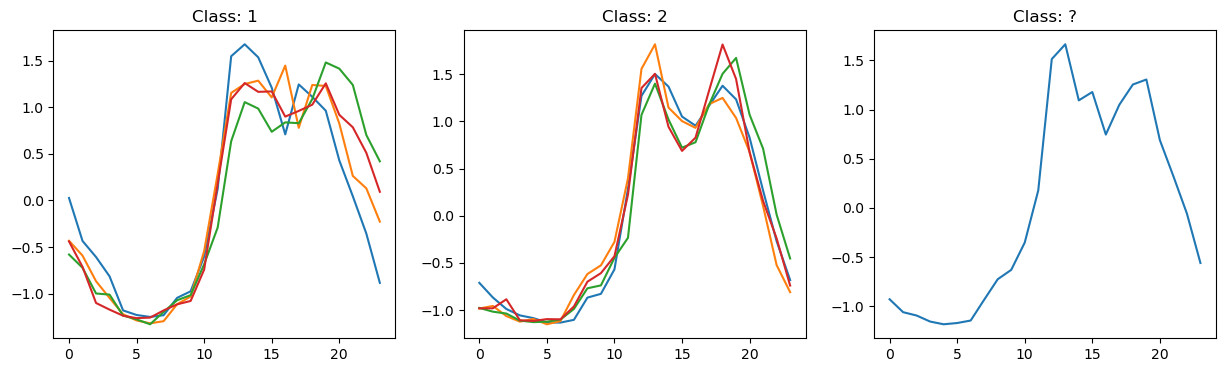

In [7]:
count_per_classes = 4 # Number of instances to plot per each class


print("shape train DS:", train_ds.shape)
print("classes:",classes,"count_per_classes=", count_per_classes,"max_class_to_plot=", max_class_to_plot)
plt.figure(figsize=(15, 4))

for i, c in enumerate(classes[:max_class_to_plot]):
    print ("i=",i,"c=",c)
    print ("y_train==c:",np.where(y_train==c)[0])
    ts_indices = np.random.choice(np.where(y_train==c)[0], size=count_per_classes+1, replace=False)
    print ("ts_indices:",ts_indices)
    plt.subplot(1, max_class_to_plot+1, i+1)
    for idx in ts_indices[:-1]:
        print("idx=",idx)
        plt.plot(znormalize_array(X_train[idx])) # z-normalize the times series to make sure they are on the same scale
    plt.title(f'Class: {c}')
    
plt.subplot(1, max_class_to_plot+1, i+2)
plt.plot(znormalize_array(X_train[ts_indices[-1]]))
print(ts_indices[-1])
plt.title(f'Class: ?')
plt.savefig(fname='images/chinatown-multi-instance-classification.jpg')

# The SAST model

In [11]:
min_shp_length = 3
max_shp_length = X_train.shape[1]
print("shape X_train DS:", X_train.shape)
candidate_lengths = np.arange(min_shp_length, max_shp_length+1)
# candidate_lengths = (3, 7, 9, 11)
nb_inst_per_class = 1
print('candidate_lengths:',candidate_lengths)

shape X_train DS: (20, 24)
candidate_lengths: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


## SAST with RidgeClassifier

In [13]:
start = time.time()

ridge = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
#print("np.logspace(-3, 3, 10): ",np.logspace(-3, 3, 10))

sast_ridge = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state= random_state, classifier=ridge)
sast_ridge.fit(X_train, y_train)

print('score:', sast_ridge.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.9475218658892128
duration: 0.8339443206787109


c: 1  ts: [[ 525.  431.  248.  240.   91.   64.   29.  117.  200.  236.  456.  717.
  1331. 1609. 1563. 1398. 1465. 1459. 1631. 1891. 1847. 1731. 1375. 1188.]]


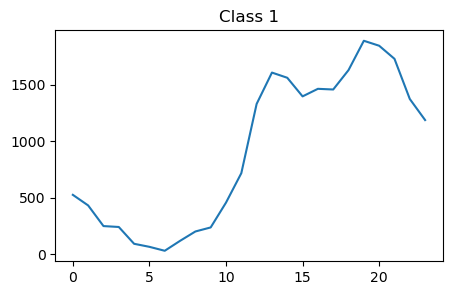

c: 2  ts: [[  95.   63.   45.   26.    3.   23.   28.  108.  209.  241.  372.  549.
  1206. 1223. 1156. 1102. 1083. 1107. 1109. 1193.  900.  660.  442.  226.]]


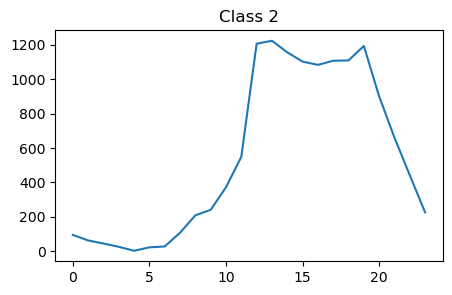

In [10]:
plot_kernel_generators(sast_ridge)

## Let's plot the top most important features over the generators

1 (1, 24)


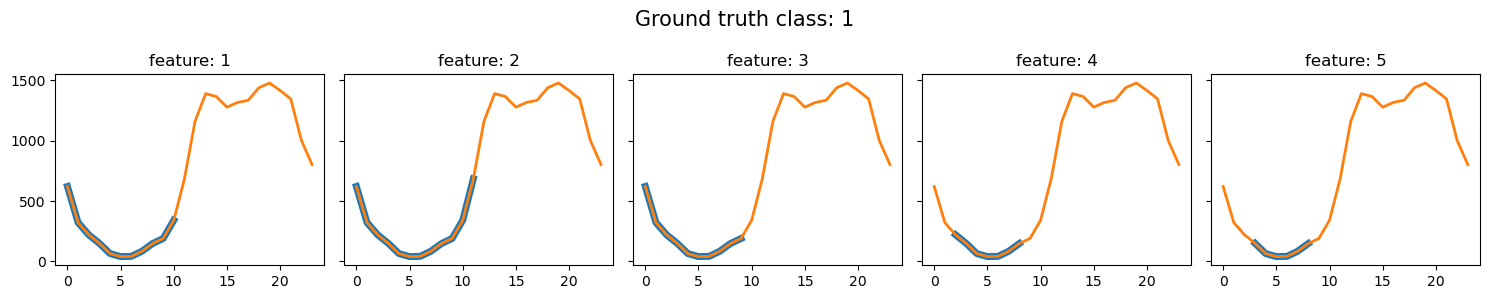

2 (1, 24)


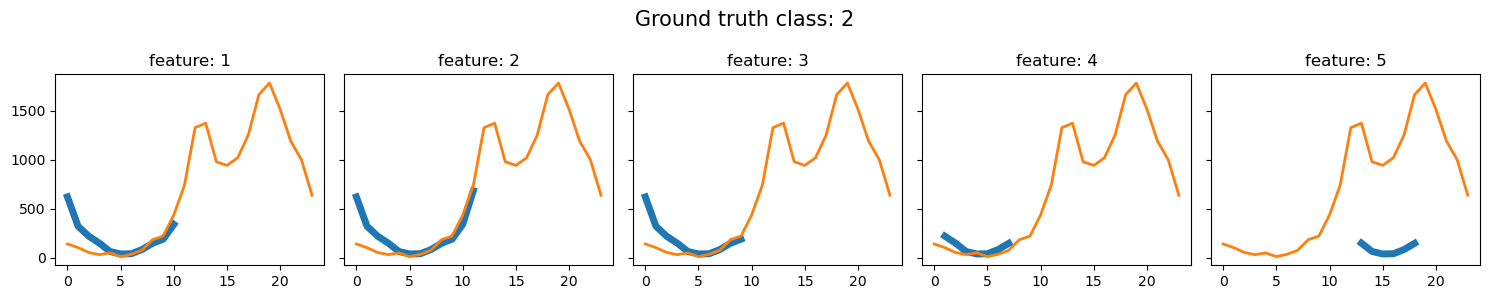

In [12]:
for c, ts in sast_ridge.kernels_generators_.items():
    fname = f'images/chinatown-ridge-class{c}-top5-features-on-ref-ts.jpg'
    print(c,ts.shape )
    plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=0, fname=fname) # plot only the first model one-vs-all model's features

# for c, ts in sast_ridge.kernels_generators_.items():
#     plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=5)

# for c, ts in sast_ridge.kernels_generators_.items():
#     plot_most_important_feature_on_ts(ts.squeeze(), c, sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], limit=5, offset=10)

## Let's plot the top best features on some test instances

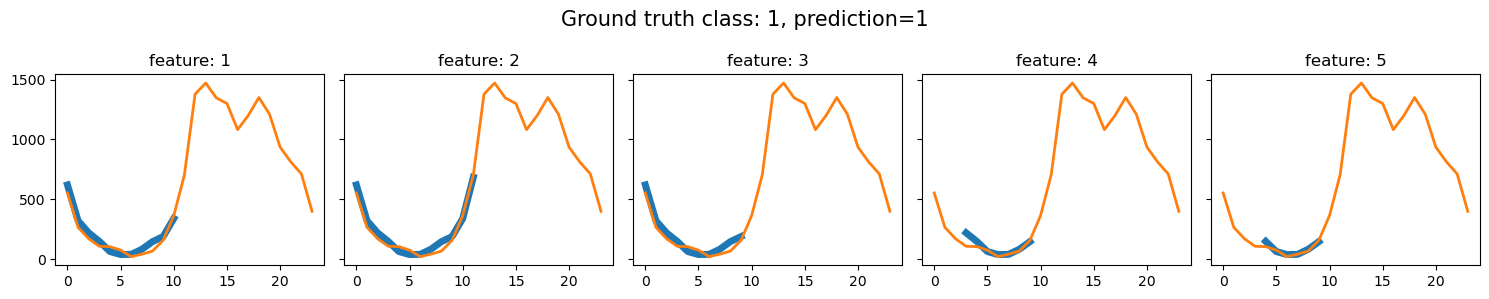

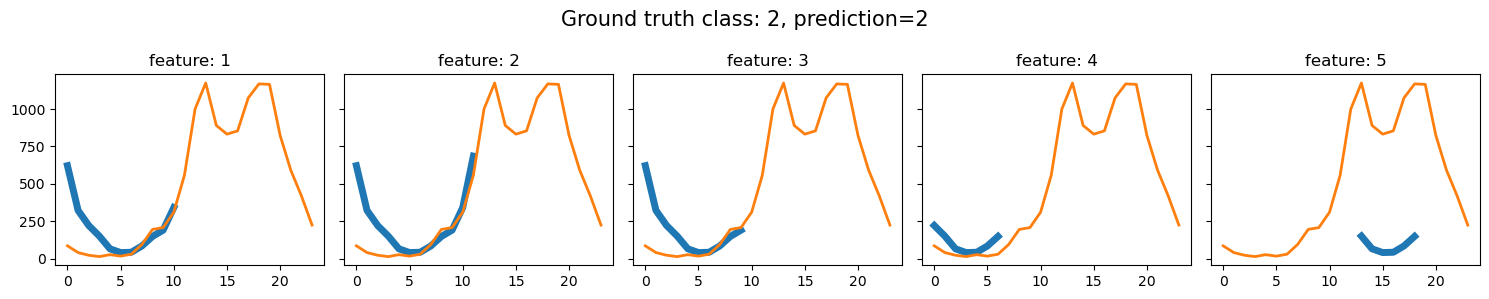

In [13]:
classes = np.unique(y_test)
for c in classes[:2]:
    idx = np.random.choice(np.where(y_test==c)[0])
    ts = X_test[idx]
    pred = sast_ridge.predict(np.expand_dims(ts, axis=0))[0]
    
    fname = f'images/chinatown-ridge-test-top5-features-on-ts-{idx}.jpg'
    plot_most_important_feature_on_ts(ts, f'{c}, prediction={pred}', sast_ridge.kernel_orig_, sast_ridge.classifier.coef_[0], fname=fname) # plot only the first model one-vs-all model's features

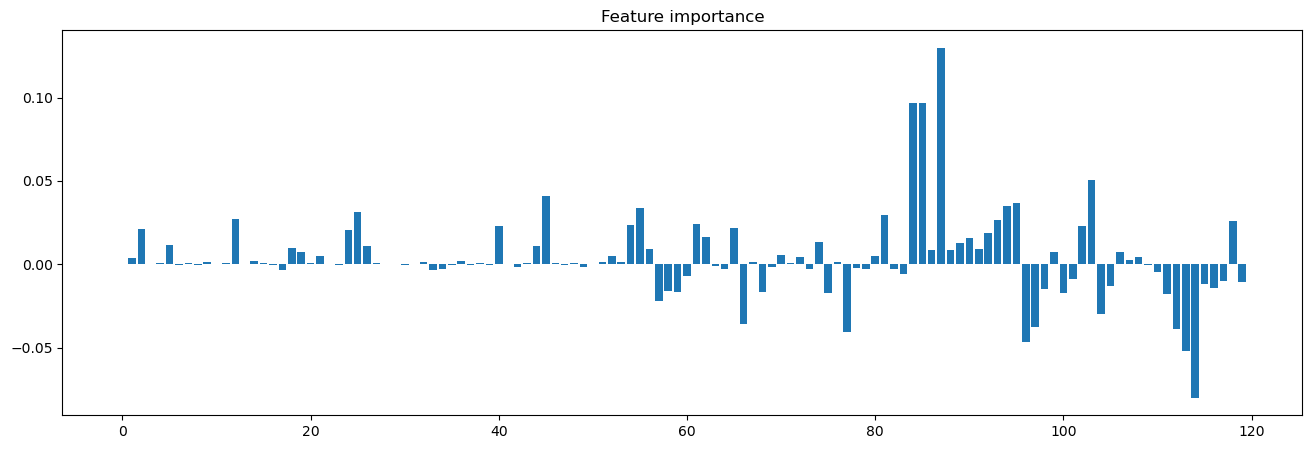

120


<Figure size 640x480 with 0 Axes>

In [42]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance')
plt.bar([i for i in range(sast_ridge.classifier.coef_[0].size)], sast_ridge.classifier.coef_[0]) # plot only the first model one-vs-all model's features
plt.show()
plt.savefig('images/chinatown-ridge-features-importance.jpg')
print(sast_ridge.classifier.coef_[0].size)

## SAST with RandomForest

In [43]:
start = time.time()

rf = RandomForestClassifier(max_features=None, min_impurity_decrease=0.05)

sast_rf = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=rf)
sast_rf.fit(X_train, y_train)

print('score:', sast_rf.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.8862973760932945
duration: 0.4013345241546631


## Let's plot the top most important features overs the generators

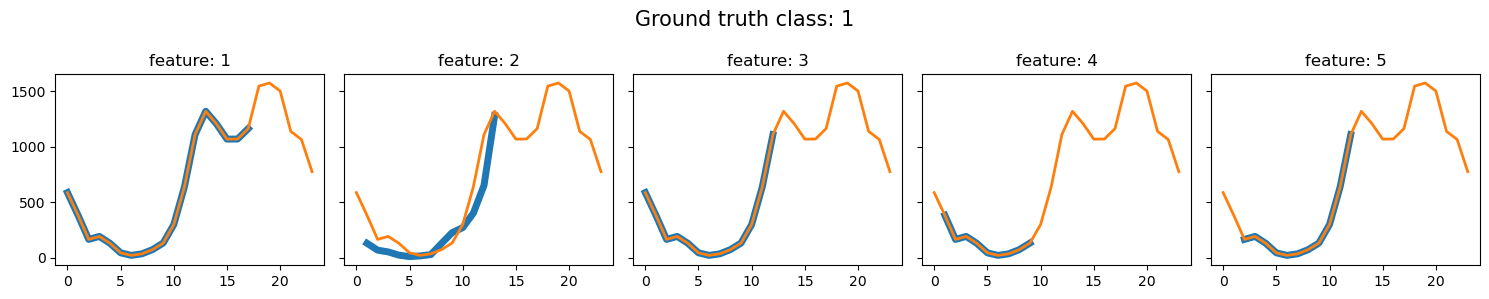

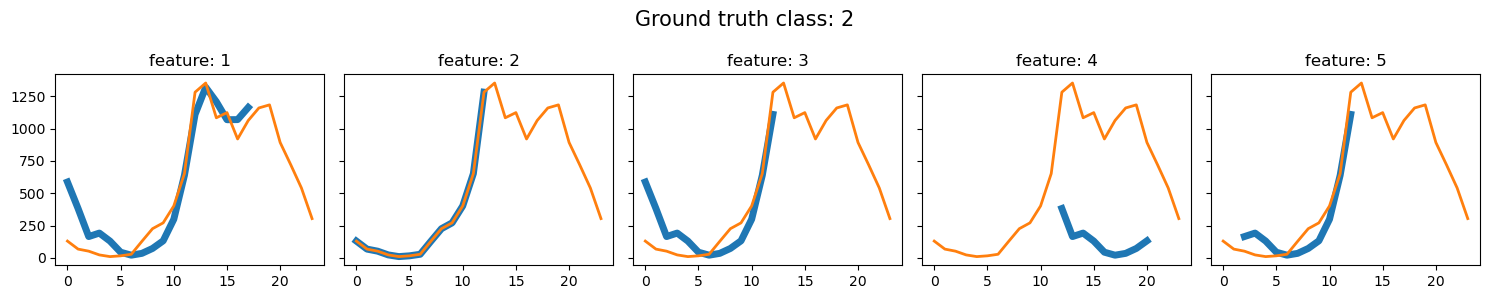

In [16]:
for c, ts in sast_rf.kernels_generators_.items():
    fname = f'images/chinatown-rf-class{c}-top5-features-on-ref-ts.jpg'
    plot_most_important_feature_on_ts(ts.squeeze(), c, sast_rf.kernel_orig_, sast_rf.classifier.feature_importances_, fname=fname)

## Plotting the top best features on some test instances

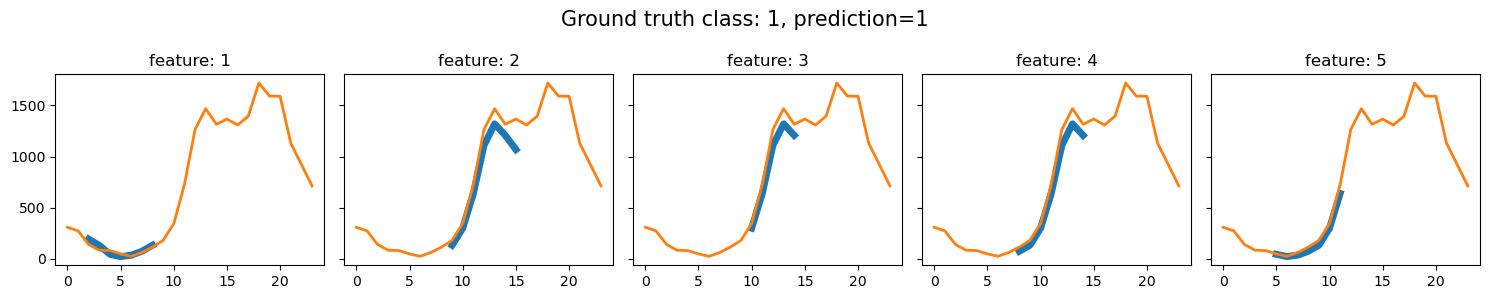

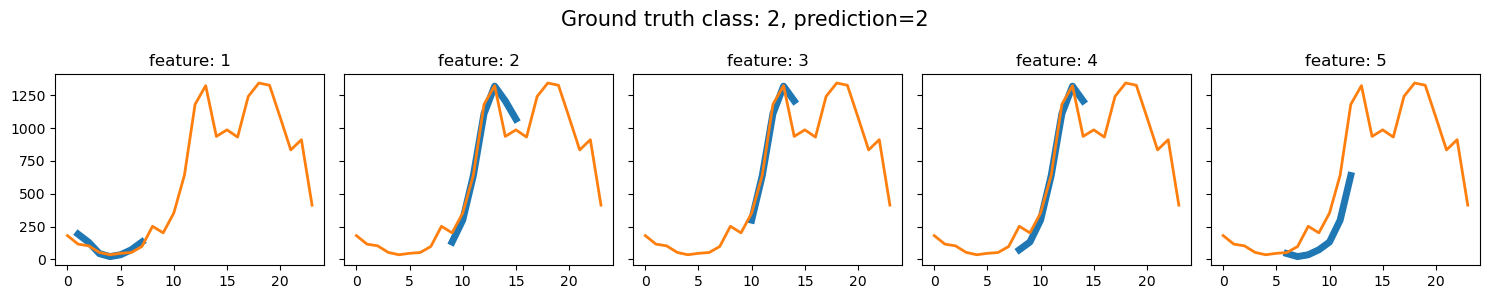

In [44]:
classes = np.unique(y_test)
for c in classes[:2]:
    idx = np.random.choice(np.where(y_test==c)[0])
    ts = X_test[idx]
    pred = sast_rf.predict(np.expand_dims(ts, axis=0))[0]
    
    fname = f'images/chinatown-rf-test-top5-features-on-ts-{idx}.jpg'
    plot_most_important_feature_on_ts(ts, f'{c}, prediction={pred}', sast_rf.kernel_orig_, sast_rf.classifier.feature_importances_, fname=fname)

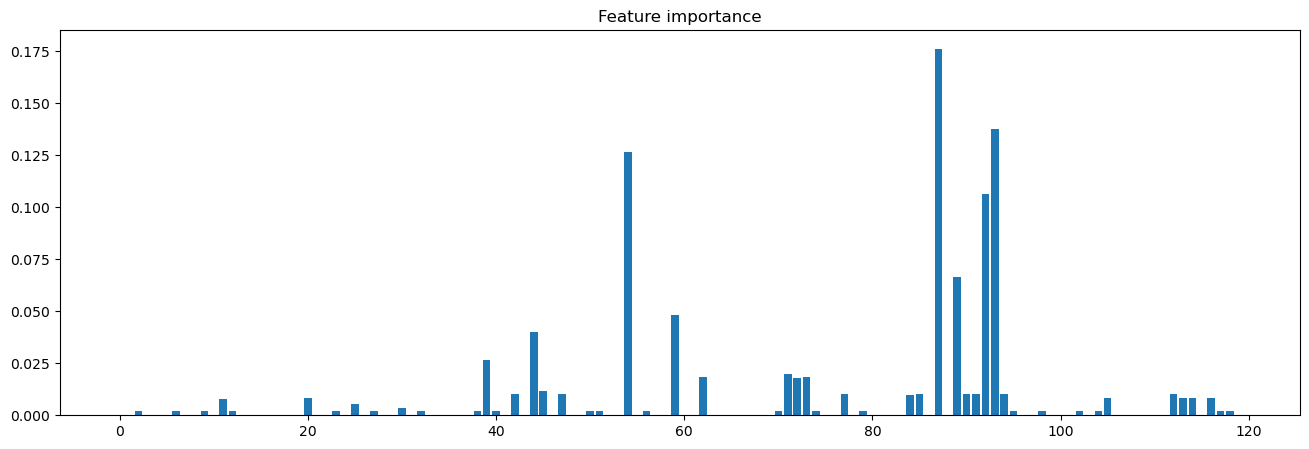

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure(figsize=(16, 5))
plt.title('Feature importance')
plt.bar([i for i in range(sast_rf.classifier.feature_importances_.size)], sast_rf.classifier.feature_importances_)
plt.show()
plt.savefig('images/chinatown-rf-features-importance.jpg')

# Ensemble of weak SAST   

A weak SAST model is a SAST model that uses fixed length subsequences. It is faster dans a regular SAST model, could be less accurate

In [19]:
candidate_lengths = (3, 5, 7)

clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))

sast_rf = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=clf)

start = time.time()

sast_rf.fit(X_train, y_train)

print('score:', sast_rf.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

score: 0.8483965014577259
duration: 0.27627015113830566


In [20]:
candidate_length_list = [list(range(3, 10)), list(range(10, 17)), list(range(17, 24))]
clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf = RandomForestClassifier(min_impurity_decrease=0.05, max_features=None)
saste = SASTEnsemble(cand_length_list=candidate_length_list,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state, classifier=clf, n_jobs = -1)

start = time.time()

saste.fit(X_train, y_train)

print('Score:', saste.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

Score: 0.9650145772594753
duration: 12.48025393486023


In [21]:
saste

SASTEnsemble(cand_length_list=[[3, 4, 5, 6, 7, 8, 9],
                               [10, 11, 12, 13, 14, 15, 16],
                               [17, 18, 19, 20, 21, 22, 23]],
             classifier=RandomForestClassifier(max_features=None,
                                               min_impurity_decrease=0.05),
             n_jobs=-1)

### GridSearch of weights

In [22]:
candidate_length_list

[[3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21, 22, 23]]

In [23]:
from itertools import combinations

weights = np.linspace(0, 1, len(candidate_length_list))
weights

array([0. , 0.5, 1. ])

In [24]:
from sklearn.model_selection import GridSearchCV

#params = {'weights': [(0.5, 0.5), (0.3, 0.7), (0.7, 0.3)]}
params = {'weights': [ (0.3, 0.6,0.1), (0.5, 0.3,0.2),(0.5, 0.5, 0.0)]}
saste_grid = GridSearchCV(estimator=saste, param_grid=params, cv=4, n_jobs = -1)

start = time.time()

saste_grid.fit(X_train, y_train)

print('Score:', saste_grid.score(X_test, y_test))

end = time.time()

print('duration:', end-start)

saste_grid.set_params

Score: 0.9708454810495627
duration: 13.672152757644653


<bound method BaseEstimator.set_params of GridSearchCV(cv=4,
             estimator=SASTEnsemble(cand_length_list=[[3, 4, 5, 6, 7, 8, 9],
                                                      [10, 11, 12, 13, 14, 15,
                                                       16],
                                                      [17, 18, 19, 20, 21, 22,
                                                       23]],
                                    classifier=RandomForestClassifier(max_features=None,
                                                                      min_impurity_decrease=0.05),
                                    n_jobs=-1),
             n_jobs=-1,
             param_grid={'weights': [(0.3, 0.6, 0.1), (0.5, 0.3, 0.2),
                                     (0.5, 0.5, 0.0)]})>

# Using Shapelet Transform

In [25]:
#from sktime.utils.data_container import detabularise
#from sktime.transformers.series_as_features.shapelets import ShapeletTransform
from sktime.transformations.panel.shapelet_transform import ShapeletTransform
from sktime.datatypes._panel._convert import from_2d_array_to_nested


In [26]:
def plot_shapelets(st, X_train, y_train, nb_shapelet = np.inf, offset = 0, fname=None):
    shapelet_per_time_series = {}
    max_ = min(len(st.shapelets), nb_shapelet)
    for i in range(offset, max_ + offset):
        s = st.shapelets[i]
        # summary info about the shapelet
        print("#"+str(i)+": "+str(s))
        if s.series_id in shapelet_per_time_series:
            shapelet_per_time_series[s.series_id].append(s)
        else:
            shapelet_per_time_series[s.series_id] = [s,]
    
    max_ = len(shapelet_per_time_series)
    fig, axes = plt.subplots(1, max_, figsize= (3*max_, 3), tight_layout=True)
    for i, ts_id in enumerate(shapelet_per_time_series.keys()):
        ts_normalized = znormalize_array(X_train.iloc[ts_id,0].values)
        for j, s in enumerate(shapelet_per_time_series[ts_id]):
            # overlay shapelets
            axes[i].plot(
                list(range(s.start_pos,(s.start_pos+s.length))),
                ts_normalized[s.start_pos:s.start_pos+s.length],
                linewidth=5
            )
        axes[i].plot(ts_normalized)
        axes[i].set_title(f'Time series: {ts_id}, class: {y_train[ts_id]}')
    if fname is not None:
        plt.savefig(fname=fname)
    plt.show()

In [27]:
# convert our dataset to sktime format
X_train_sktime = from_2d_array_to_nested(pd.DataFrame(X_train))
X_test_sktime = from_2d_array_to_nested(pd.DataFrame(X_test))
print(X_train.shape)
print(X_train_sktime.shape)

(20, 24)
(20, 1)


## ST

In [28]:
start = time.time()

st = ShapeletTransform(min_shapelet_length=min_shp_length, max_shapelet_length=np.inf)
st.fit(X_train_sktime, y_train)

X_train_transformed = st.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = st.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test)) # Score: 0.9737609329446064 on Chinatown
print('Duration:', end - start)

Score: 0.9766763848396501
Duration: 75.37241864204407


#0: Series ID: 0, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 
#1: Series ID: 3, start_pos: 0, length: 14, info_gain: 0.9980008838722996, 
#2: Series ID: 18, start_pos: 3, length: 9, info_gain: 0.9980008838722996, 
#3: Series ID: 8, start_pos: 4, length: 7, info_gain: 0.9980008838722996, 
#4: Series ID: 19, start_pos: 1, length: 9, info_gain: 0.9980008838722996, 


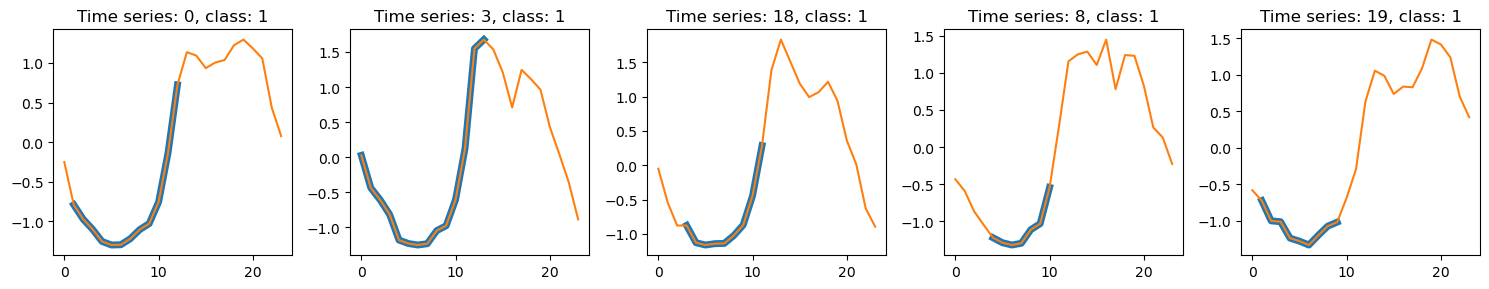

#5: Series ID: 7, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#6: Series ID: 17, start_pos: 1, length: 11, info_gain: 0.9980008838722996, 
#7: Series ID: 16, start_pos: 0, length: 11, info_gain: 0.9980008838722996, 
#8: Series ID: 14, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#9: Series ID: 6, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 


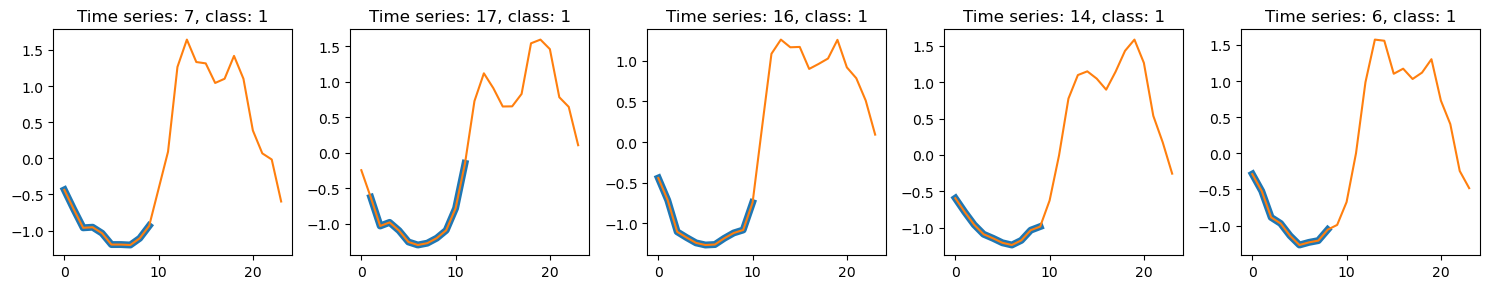

#10: Series ID: 2, start_pos: 0, length: 14, info_gain: 0.9980008838722996, 
#11: Series ID: 1, start_pos: 3, length: 11, info_gain: 0.9980008838722996, 
#12: Series ID: 11, start_pos: 4, length: 12, info_gain: 0.9980008838722996, 
#13: Series ID: 13, start_pos: 1, length: 13, info_gain: 0.9980008838722996, 
#14: Series ID: 15, start_pos: 0, length: 17, info_gain: 0.9980008838722996, 


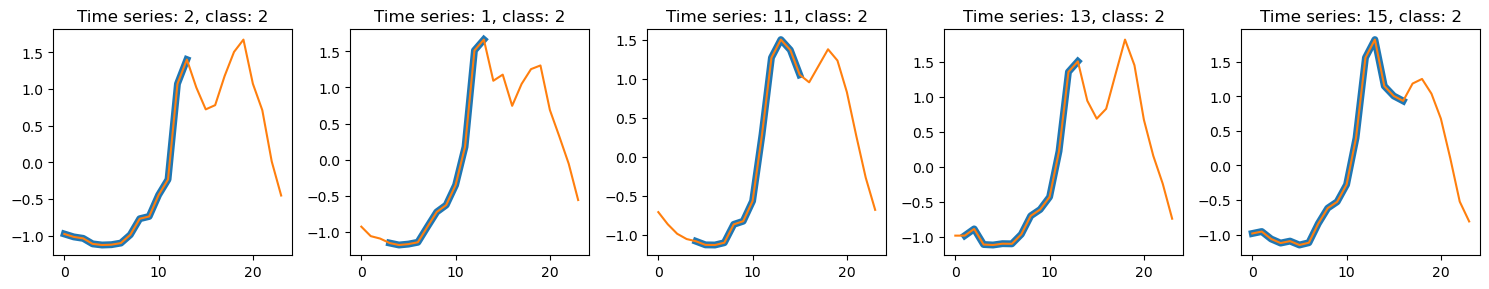

#15: Series ID: 10, start_pos: 0, length: 15, info_gain: 0.9980008838722996, 
#16: Series ID: 9, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 
#17: Series ID: 12, start_pos: 1, length: 9, info_gain: 0.9980008838722996, 
#18: Series ID: 5, start_pos: 1, length: 12, info_gain: 0.9980008838722996, 
#19: Series ID: 4, start_pos: 0, length: 13, info_gain: 0.9980008838722996, 


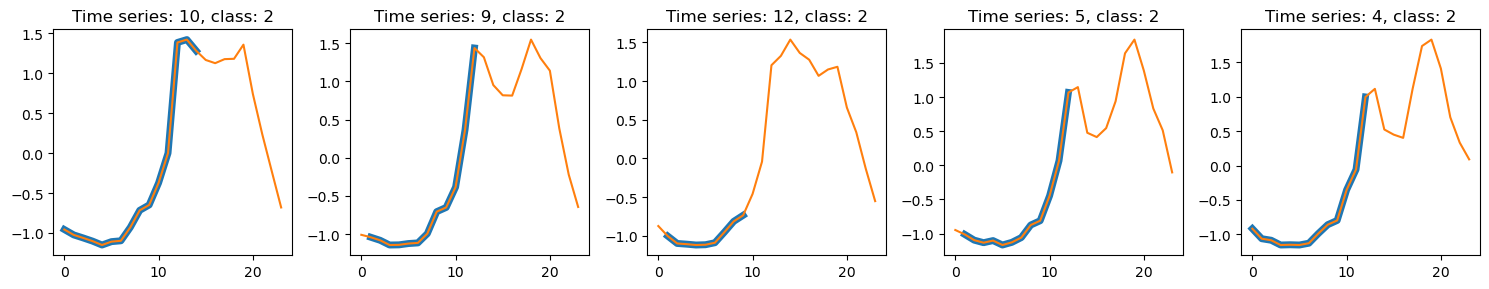

In [29]:
ncols = 5
for start in range(len(st.shapelets) // ncols):
    plot_shapelets(st, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname=f'images/chinatown-shapelets-{start}.jpg')

**Observation:** By using more than one instance by class, the model behaves like it is learning noisy versions of the same shaphelets

## OneShot ST

### OneShot ST 1:

Here, shapelets are selected using only the generators from KernelsGenerator  
The limitation of this approach is that the quality of a shapelet candidate is not computed on the whole training set, but only on the generators

In [30]:
# create the dataset to learn shapelet from
sast = SAST(cand_length_list=candidate_lengths,
                          nb_inst_per_class=nb_inst_per_class, 
                          random_state=random_state)

sast.init_sast(X_train, y_train) 

y_resample = np.array(list(sast.kernels_generators_.keys()), dtype=np.int32)
X_resample = [t.squeeze() for _, t in sast.kernels_generators_.items()]
X_resample = np.array(X_resample, dtype=np.float32)
X_resample_sktime = from_2d_array_to_nested(pd.DataFrame(X_resample))

start = time.time()

ost1 = ShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf)

ost1.fit(X_resample_sktime, y_resample)

X_train_transformed = ost1.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost1.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)

Score: 0.4956268221574344
duration: 0.6722924709320068


for: 0
#0: Series ID: 0, start_pos: 0, length: 3, info_gain: 0, 
#1: Series ID: 1, start_pos: 0, length: 3, info_gain: 0, 


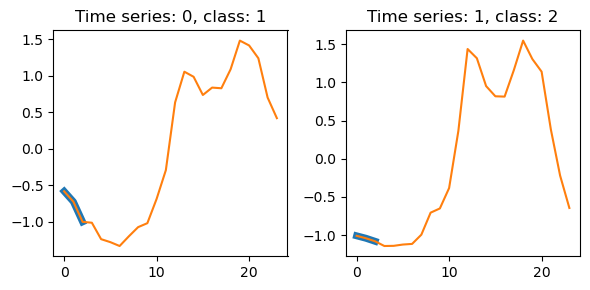

In [31]:
ncols = 5 if len(ost1.shapelets) > 5 else len(ost1.shapelets)
for start in range(len(ost1.shapelets) // ncols):
    print ("for:",start)
    plot_shapelets(ost1, X_resample_sktime, y_resample, offset=start * ncols, nb_shapelet = ncols)

### OneShot ST 2:

Here we fix the limitation of the previous part by generating shapelet candidates from only `nb_inst_per_class` for each class, however the quality of each shapelet is computed over the whole training set

In [32]:
from sast.stck import ShapeletTransformK

NameError: name 'ContractedShapeletTransform' is not defined

In [ ]:
start = time.time()

ost2 = ShapeletTransformK(min_shapelet_length=min_shp_length, 
                          max_shapelet_length=np.inf, 
                          nb_inst_per_class=nb_inst_per_class)
ost2.fit(X_train_sktime, y_train)

X_train_transformed = ost2.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost2.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost2.nb_inst_per_class)

NameError: name 'ShapeletTransformK' is not defined

In [ ]:
ncols = 5 if len(ost2.shapelets) > 5 else len(ost2.shapelets)
for start in range(len(ost2.shapelets) // ncols):
    plot_shapelets(ost2, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname='images/chinatown-shapelet-1ST.jpg')

NameError: name 'ost2' is not defined

In [ ]:
start = time.time()

ost3 = OShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf, 
                        nb_inst_per_class=2)
ost3.fit(X_train_sktime, y_train)

X_train_transformed = ost3.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost3.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost3.nb_inst_per_class)

Score: 0.9737609329446064
duration: 11.781237363815308
nb inst per class: 2


#0: Series ID: 18, start_pos: 0, length: 10, info_gain: 0.9980008838722996, 
#1: Series ID: 15, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 
#2: Series ID: 7, start_pos: 3, length: 10, info_gain: 0.9980008838722996, 
#3: Series ID: 11, start_pos: 0, length: 13, info_gain: 0.9980008838722996, 


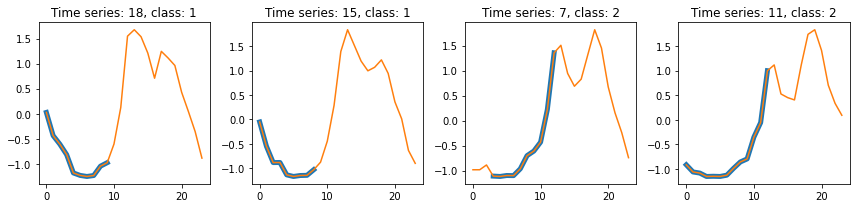

In [ ]:
ncols = 5 if len(ost3.shapelets) > 5 else len(ost3.shapelets)
for start in range(len(ost3.shapelets) // ncols):
    plot_shapelets(ost3, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols, fname='images/chinatown-shapelet-2ST.jpg')

In [ ]:
start = time.time()

ost4 = OShapeletTransform(min_shapelet_length=min_shp_length, 
                        max_shapelet_length=np.inf, 
                        nb_inst_per_class=3)
ost4.fit(X_train_sktime, y_train)

X_train_transformed = ost4.transform(X_train_sktime)

clf = RandomForestClassifier()
clf.fit(X_train_transformed, y_train)

end = time.time()

X_test_transformed = ost4.transform(X_test_sktime)

print('Score:', clf.score(X_test_transformed, y_test))
print('duration:', end - start)
print('nb inst per class:', ost4.nb_inst_per_class)

NameError: name 'OShapeletTransform' is not defined

#0: Series ID: 14, start_pos: 0, length: 12, info_gain: 0.9980008838722996, 
#1: Series ID: 5, start_pos: 0, length: 9, info_gain: 0.9980008838722996, 


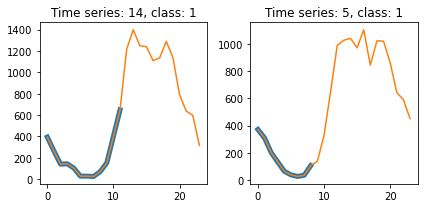

In [ ]:
ncols = 5 if len(ost1.shapelets) > 5 else len(ost1.shapelets)
for start in range(len(ost1.shapelets) // ncols):
    plot_shapelets(ost4, X_train_sktime, y_train, offset=start * ncols, nb_shapelet = ncols)

## Using ROCKET:



In [36]:
from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.kernel_based import RocketClassifier


In [ ]:
X_train, y_train = load_UCR_UEA_dataset(name="Chinatown",extract_path='data', split="train")
X_test, y_test = load_UCR_UEA_dataset(name="Chinatown",extract_path='data', split="test")

In [38]:
rocket= RocketClassifier(num_kernels=10_000)#proposed 10000 because it is more stable
rocket.fit(X_train,y_train)

RocketClassifier()

In [39]:
rocket.score(X_test,y_test)

0.9825072886297376